# <font color=red><center><b>BBM409 : Introduction to Machine Learning Lab - Assignment 4</b></center></font>

<center><img src="https://upload.wikimedia.org/wikipedia/tr/2/28/Hacettepe_%C3%9Cniversitesi_Logosu.svg" />

## <font color=black><center>Berra Nur SARI - 21727671 <br> Melih SUNMAN - 21827809</center></font>

## Part 1: Multi Layer Neural Network

- In this part of the assignment, we implement multi layer neural network for classification. Created network consists of one input layer, n hidden layer(s) and one output layer. We implemented forward and backward propagations with the loss function and learning setting. Actually, we implemented a back-propagation algorithm to train a neural network.

### Implementing Artificial Neural Network

<i style="color:green"> Required libraries are imported </i>

In [73]:
import numpy as np
import pandas as pd
import os

#For Preprocessing
import cv2
import itertools
from tqdm.notebook import tqdm
#from tqdm import tqdm_notebook as tqdm
from PIL import Image, ImageOps

#Additional imports for functionality
from sklearn.utils import class_weight, shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#For Graphing and Plotting Images
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline

#For Create Tables
from prettytable import PrettyTable 

<i style="color:green"> Getting foldernames from dataset </i>

In [2]:
foldernames = os.listdir('raw-img')

<i style="color:green"> Creating Empty lists for categories and the files </i>

In [3]:
categories = []
files = []
i = 0

<i style="color:green"> Going over all the folders and their categories in the foldernames </i>

In [4]:
for k, folder in enumerate(foldernames):
    print(k , folder)
    #Getting the filenames
    filenames = os.listdir("raw-img/" + folder);
    for file in filenames:
        #Appending all the image files into one list
        files.append("raw-img/" + folder + "/" + file)
        #Appending categories into one list
        categories.append(k)

0 cane
1 cavallo
2 elefante
3 farfalla
4 gallina
5 gatto
6 mucca
7 pecora
8 ragno
9 scoiattolo


<i style="color:green"> Defining a DataFrame to store data </i>

In [5]:
df = pd.DataFrame({
    'filename': files,
    'category': categories
})
df

,filename,category
0,raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg,0
1,raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg,0
2,raw-img/cane/OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg,0
3,raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg,0
4,raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg,0
...,...,...
26174,raw-img/scoiattolo/OIP-_U7JiIoYjbWPqmmmmdsvJwH...,9
26175,raw-img/scoiattolo/OIP-_VBkNQd_MZI4xoemUb-FtAH...,9
26176,raw-img/scoiattolo/OIP-_WyHKgREia-4VijlL6DNswH...,9
26177,raw-img/scoiattolo/OIP-_xFGMN0UbYduHdiXQ1maZAH...,9


<i style="color:green"> Preprocessing on images: </i>
- We want to train the network feeding by given training set as gray-level image values and size of images are 32x32. For this reason, we converted the pictures to black and white and changed their size.
- Since the data to be used during ANN training will be flatten, we converted our matrices to flatten and normalized them.

In [6]:
images = []

def process_image(img_path: str) -> np.array:
    img = Image.open(img_path)
    #to convert the image to grayscale
    img = ImageOps.grayscale(img)
    #to resizes our image (32 pixels wide and tall)
    img = img.resize(size=(32, 32))
    #to flatten the image and normalization
    img = np.ravel(img) / 255.0
    return img

#tqdm is used for visualing the progress of the image preprocessing as a progress bar
with tqdm(total=len(df)) as pbar:
    #Going over all the filenames in train_df
    for i, file_path in enumerate(df.filename.values):
        img = process_image(file_path)
        images.append(img)
        pbar.update(1)

  0%|          | 0/26179 [00:00<?, ?it/s]

In [26]:
images = np.array(images)
images.shape

(26179, 1024)

<i style="color:green"> This is an example to show how preprocessing works  </i>

[0.45490196 0.47058824 0.47843137 ... 0.57647059 0.57647059 0.60392157]


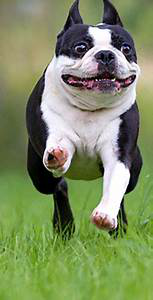

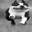

In [27]:
example_path = df.filename.values[2]
test_image = process_image(example_path)
print(test_image)
src_img = Image.open(example_path)
display(src_img)

#Reverse the last step to represent the image visually with using array
Image.fromarray(np.uint8(test_image * 255).reshape((32, 32)))

<i style="color:green"> Shuffle the data and convert to numpy  </i>

In [28]:
#Assigning x and y to be the values and their target labels respectively
x = df['filename']
y = df['category']

#Getting a list of the number of images used and a random index permutation from the data
#to randomly append images into x_shuffle along with their labels
data_num = len(y)
random_index = np.random.permutation(data_num)

#Shuffling the data
x, y = shuffle(x, y)

#Empty lists to store shuffled data
x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

In [29]:
x.shape , y.shape

((26179, 1024), (26179,))

<i style="color:green"> Partitioning 20% of the dataset into test set and partitioning 20% of the dataset into validation set  </i>

In [30]:
split_num = int(round(0.2*len(y)))
split_num

5236

<i style="color:green"> 60% of the data set was divided into training set, 20% validation set, and 20% test set  </i>

In [31]:
x_train = x[:len(y)-split_num*2]
y_train = y[:len(y)-split_num*2]
print("size of training sets   " , x_train.shape , " " , y_train.shape)

x_validation = x[len(y)-split_num*2:len(y)-split_num]
y_validation = y[len(y)-split_num*2:len(y)-split_num]
print("size of validation sets " ,x_validation.shape , "  " , y_validation.shape)

x_test = x[len(y)-split_num:]
y_test = y[len(y)-split_num:]
print("size of test sets       " ,x_test.shape , "  " , y_test.shape)

size of training sets    (15707, 1024)   (15707,)
size of validation sets  (5236, 1024)    (5236,)
size of test sets        (5236, 1024)    (5236,)


<i style="color:green"> ANN class for create - train and test the model  </i>

In [105]:
class ANN(object):
    def __init__(self, train_set_samples, train_set_labels , number_of_hidden_layers , size_of_hidden_layers = 128 , batch_size = 32 , step_size = 5e-2 ,regularization_strength = 1e-3 , epoch = 3000):
        self.X = train_set_samples
        self.y = train_set_labels
        self.number_of_hidden_layers = number_of_hidden_layers
        self.batch_size = batch_size
        self.epoch = epoch
        
        self.D = 32*32 #size of images
        self.K = 10 #number of classes
        self.h = size_of_hidden_layers   #size of hidden layer
       
        self.step_size = step_size
        self.reg = regularization_strength # regularization strength
        
        self.weights_list = []
        self.biases_list = []
        self.hidden_layer_score=[]
        
        self.loss = 0
        self.losses = [];
    
    def create_hidden_layer(self, n_inputs): #32*32 or 128
        weights = 0.01 * np.random.randn(n_inputs, self.h)
        self.weights_list.append(weights)
        biases = np.zeros((1, self.h))
        self.biases_list.append(biases)
    
    def create_final_layer(self):
        self.softmax_weights = 0.01 * np.random.randn(self.h, self.K)
        self.softmax_biases  = np.zeros((1,self.K))
        
    def softmax(self, scores):
        expX = np.exp(scores)
        return expX / np.sum(expX, axis=1, keepdims=True)# [N x K]
    
    def relu(self, data):
        return np.maximum(0, data)
    
    #average cross-entropy loss and regularization
    def compute_the_loss(self, labels , probs):
        correct_logprobs = -np.log(probs[range(len(labels)),labels])
        data_loss = np.sum(correct_logprobs)/len(labels)
        reg_loss = 0
        for i in range(len(self.weights_list)):
            reg_loss += 0.5*self.reg*np.sum(self.weights_list[i] ** 2) 
        reg_loss += 0.5*self.reg*np.sum(self.softmax_weights ** 2) 
        self.loss = data_loss + reg_loss
        
    def gradient(self, labels, probs):
        dscores = probs
        dscores[range(len(labels)),labels] -= 1
        dscores /= len(labels)
        return dscores
        
    def backpropate(self,dscores):
        d_hiddens_list = []
        d_weights_list = []
        d_biases_list = []
        j = self.number_of_hidden_layers
        
        d_softmax_weights = np.dot(self.hidden_layer_score[j].T, dscores)
        d_softmax_biases = np.sum(dscores, axis=0, keepdims=True)
        
        dhidden = np.dot(dscores, self.softmax_weights.T)
        
        dhidden[self.hidden_layer_score[j] <= 0] = 0
        
        
        for i in range(self.number_of_hidden_layers):
            j -= 1
            d_weights_list.insert(0, np.dot(self.hidden_layer_score[j].T, dhidden))
            d_biases_list.insert(0, np.sum(dhidden, axis=0, keepdims=True))
            dhidden = np.dot(dhidden, self.weights_list[j].T)
            dhidden[self.hidden_layer_score[j] <= 0] = 0
            

        # add regularization gradient contribution
        d_softmax_weights += self.reg * self.softmax_weights
        for i in range(len(d_weights_list)):
            d_weights_list[i] +=  self.reg * self.weights_list[i]
            
        for i in range(len(self.weights_list)):
            self.weights_list[i] += -self.step_size* d_weights_list[i]
            self.biases_list[i] += -self.step_size* d_biases_list[i]
        self.softmax_weights += -self.step_size* d_softmax_weights
        self.softmax_biases += -self.step_size* d_softmax_biases
        
    def plot_cost(self):
        plt.figure()
        plt.plot(np.arange(len(self.losses)), self.losses)
        plt.xlabel("epochs")
        plt.ylabel("cost")
        plt.show()
        
    def create_batch(self, batch_size=32):
        mini_batches=[]
        no_of_batches=self.X.shape[0]//batch_size
        temp = 0
        
        for i in range(no_of_batches):
            mini_batchX = self.X[i*batch_size:(i+1)*batch_size]
            mini_batchY = self.y[i*batch_size:(i+1)*batch_size]
            mini_batches.append((mini_batchX,mini_batchY))
            
        if self.X.shape[0] % batch_size != 0:
            mini_batchX = self.X[(i+1)*batch_size:]
            mini_batchY = self.y[(i+1)*batch_size:]
            mini_batches.append((mini_batchX,mini_batchY))
            
        return mini_batches
        
    def train(self):

        for i in range(self.number_of_hidden_layers):
            if(i == 0):
                self.create_hidden_layer(self.D)
            else:
                self.create_hidden_layer(self.h)
        self.create_final_layer()
        
        batches = self.create_batch(self.batch_size)
       
        for iteration in range(self.epoch):
            flag = True
            loss_flag = True
            for batch in batches:
            
                data_set = batch[0]
                batch_labels = batch[1]
                
                self.hidden_layer_score = []
                self.hidden_layer_score.append(data_set)

                for i in range(self.number_of_hidden_layers):
                    if(i == 0):
                        score = self.relu(np.dot(data_set, self.weights_list[i]) + self.biases_list[i])
                        self.hidden_layer_score.append(score)
                    else:
                        score = self.relu(np.dot(score, self.weights_list[i]) + self.biases_list[i])
                        self.hidden_layer_score.append(score)
                score = np.dot(score, self.softmax_weights) + self.softmax_biases
                #self.hidden_layer_score.append(score)
                probabilities = self.softmax(score)        
                self.compute_the_loss(batch_labels, probabilities)
                if loss_flag:
                    self.losses.append(self.loss)
                    loss_flag = False
                if flag and iteration % 250 == 0 :
                    print("iteration %d: loss %f" % (iteration, self.loss))
                    predicted_class = np.argmax(probabilities, axis=1)
                    print("training accuracy: %f" % (np.mean(predicted_class == batch_labels)))
                    flag = False

                dscores = self.gradient(batch_labels, probabilities)
                self.backpropate(dscores)

               
    
    def test(self, test_set, test_label_set):
        for i in range(self.number_of_hidden_layers):
            if(i == 0):
                score = self.relu(np.dot(test_set, self.weights_list[i]) + self.biases_list[i])
            else:
                score = self.relu(np.dot(score, self.weights_list[i]) + self.biases_list[i])
        score = np.dot(score, self.softmax_weights) + self.softmax_biases
        probabilities = self.softmax(score)        
        self.compute_the_loss(test_label_set,probabilities)
        
        print("loss %f" % (self.loss))
        predicted_class = np.argmax(probabilities, axis=1)
        print("test accuracy: %f" % (np.mean(predicted_class == test_label_set)))
                   
        

- The data set of 15 thousand was too large for the validation processes we will do to get the best out of the model. It was taking too long. Therefore, it was necessary to use a smaller data set to determine the model parameters. For this reason, we used a small part of the train set.

In [49]:
split_num2 = int(round(0.1*len(y_train)))
split_num2

1571

In [50]:
x_train_for_parameters = x_train[len(y_train)-split_num2:]
y_train_for_parameters = y_train[len(y_train)-split_num2:]
x_train_for_parameters.shape , y_train_for_parameters.shape

((1571, 1024), (1571,))

In [51]:
x_validation_for_parameters = x_validation[len(y_validation)-split_num2:]
y_validation_for_parameters = y_validation[len(y_validation)-split_num2:]
x_validation_for_parameters.shape , y_validation_for_parameters.shape

((1571, 1024), (1571,))

def __init__(self, train_set_samples, train_set_labels , number_of_hidden_layers , size_of_hidden_layers = 128 , 
batch_size = 32 , step_size = 5e-2 ,regularization_strength = 1e-3):


- In our first comparison, the effect of the number of hidden layers in our model on the success of the model is examined

In [52]:
model1 =  ANN(x_train_for_parameters,y_train_for_parameters,1)

In [53]:
model1.train()

iteration 0: loss 2.309643
training accuracy: 0.125000
iteration 1000: loss 0.742189
training accuracy: 0.937500
iteration 2000: loss 0.444153
training accuracy: 1.000000


In [54]:
model2 =  ANN(x_train_for_parameters,y_train_for_parameters,2)

In [55]:
model2.train()

iteration 0: loss 2.309908
training accuracy: 0.062500
iteration 1000: loss 0.311818
training accuracy: 1.000000
iteration 2000: loss 0.345530
training accuracy: 1.000000


In [56]:
model1.test(x_validation_for_parameters,y_validation_for_parameters)

loss 4.254196
test accuracy: 0.168682


In [57]:
model2.test(x_validation_for_parameters,y_validation_for_parameters)

loss 4.739755
test accuracy: 0.222788


In [77]:
table = PrettyTable(["Models", "Loss", "Accuracy"]) 
table.add_row(["Model1(1)", "4.254196", "0.168682"]) 
table.add_row(["Model2(2)", "4.739755", "0.222788"])
print(table)

+-----------+----------+----------+
|   Models  |   Loss   | Accuracy |
+-----------+----------+----------+
| Model1(1) | 4.254196 | 0.168682 |
| Model2(2) | 4.739755 | 0.222788 |
+-----------+----------+----------+


- Obviously, the model which has 2 hidden layers, has higher accuracy. For this reason, we will continue with the model that has 2 hidden layers. 

- In our second comparison, the effect of the size of hidden layers in our model on the success of the model is examined

In [59]:
model3 =  ANN(x_train_for_parameters,y_train_for_parameters,2,64)

In [61]:
model3.train()

iteration 0: loss 2.306210
training accuracy: 0.000000
iteration 1000: loss 0.325267
training accuracy: 1.000000
iteration 2000: loss 1.146797
training accuracy: 0.718750


In [62]:
model4 =  ANN(x_train_for_parameters,y_train_for_parameters,2,128)

In [63]:
model4.train()

iteration 0: loss 2.310126
training accuracy: 0.000000
iteration 1000: loss 1.876717
training accuracy: 0.468750
iteration 2000: loss 0.269963
training accuracy: 1.000000


In [64]:
model5 =  ANN(x_train_for_parameters,y_train_for_parameters,2,256)

In [65]:
model5.train()

iteration 0: loss 2.318189
training accuracy: 0.125000
iteration 1000: loss 1.284069
training accuracy: 0.718750
iteration 2000: loss 0.769369
training accuracy: 0.812500


In [66]:
model3.test(x_validation_for_parameters,y_validation_for_parameters)

loss 4.909180
test accuracy: 0.208148


In [67]:
model4.test(x_validation_for_parameters,y_validation_for_parameters)

loss 5.529141
test accuracy: 0.210694


In [68]:
model5.test(x_validation_for_parameters,y_validation_for_parameters)

loss 5.247144
test accuracy: 0.243157


In [78]:
table = PrettyTable(["Models", "Loss", "Accuracy"]) 
table.add_row(["Model3(64)", "4.909180", "0.208148"]) 
table.add_row(["Model4(128)", "5.529141", "0.210694"])
table.add_row(["Model5(256)", "5.247144", "0.243157"])
print(table)

+-------------+----------+----------+
|    Models   |   Loss   | Accuracy |
+-------------+----------+----------+
|  Model3(64) | 4.909180 | 0.208148 |
| Model4(128) | 5.529141 | 0.210694 |
| Model5(256) | 5.247144 | 0.243157 |
+-------------+----------+----------+


- The model which size of hidden layers is 256, has higher accuracy. For this reason, we will continue with the model that size of hidden layers is 256

- In our third comparison, the effect of the batch size in our model on the success of the model is examined

In [79]:
model6 =  ANN(x_train_for_parameters,y_train_for_parameters,2,256,32)

In [80]:
model6.train()

iteration 0: loss 2.319158
training accuracy: 0.031250
iteration 1000: loss 0.761739
training accuracy: 0.875000
iteration 2000: loss 0.538830
training accuracy: 0.968750


In [81]:
model7 =  ANN(x_train_for_parameters,y_train_for_parameters,2,256,64)

In [82]:
model7.train()

iteration 0: loss 2.319486
training accuracy: 0.015625
iteration 1000: loss 0.546725
training accuracy: 0.937500
iteration 2000: loss 0.616635
training accuracy: 0.921875


In [83]:
model8 =  ANN(x_train_for_parameters,y_train_for_parameters,2,256,128)

In [84]:
model8.train()

iteration 0: loss 2.318739
training accuracy: 0.109375
iteration 1000: loss 0.355840
training accuracy: 1.000000
iteration 2000: loss 0.518063
training accuracy: 0.960938


In [85]:
model6.test(x_validation_for_parameters,y_validation_for_parameters)

loss 5.142517
test accuracy: 0.245703


In [86]:
model7.test(x_validation_for_parameters,y_validation_for_parameters)

loss 5.051058
test accuracy: 0.236792


In [87]:
model8.test(x_validation_for_parameters,y_validation_for_parameters)

loss 3.202471
test accuracy: 0.212603


In [102]:
table = PrettyTable(["Models", "Loss", "Accuracy"]) 
table.add_row(["Model6(32)", "5.142517", "0.245703"]) 
table.add_row(["Model7(64)", "5.051058", "0.236792"])
table.add_row(["Model8(128)", "3.202471", "0.212603"])
print(table)

+-------------+----------+----------+
|    Models   |   Loss   | Accuracy |
+-------------+----------+----------+
|  Model6(32) | 5.142517 | 0.245703 |
|  Model7(64) | 5.051058 | 0.236792 |
| Model8(128) | 3.202471 | 0.212603 |
+-------------+----------+----------+


- We create our final model by choosing the higher accuracy ones.
- We use the real train set to train this model.

In [99]:
split_num3 = int(round(0.5*len(y_train)))

x_train_for_parameters = x_train[len(y_train)-split_num3:]
y_train_for_parameters = y_train[len(y_train)-split_num3:]
x_train_for_parameters.shape , y_train_for_parameters.shape

((7854, 1024), (7854,))

In [106]:
model9 =  ANN(x_train_for_parameters,y_train_for_parameters,2,256,32,5e-2 ,1e-3 , 1000)

In [107]:
model9.train() 

iteration 0: loss 2.318631
training accuracy: 0.093750
iteration 250: loss 0.866025
training accuracy: 0.937500
iteration 500: loss 0.714254
training accuracy: 1.000000
iteration 750: loss 0.619105
training accuracy: 1.000000


In [108]:
model9.test(x_test,y_test)

loss 3.359079
test accuracy: 0.348930


- We could not train using the whole training dataset in the model we used, because the training takes really long and time-consuming, we had to wait for it to train again after making a small change in the model, but we did not have enough time for this. When we look at the training accuracy of the model, we can say that we have an overfitting problem. There were some things we could do to resolve this. For example, we could have used more smaples during the training of the model. Another option would be to change the size of the images we use. If we had worked with 128x128 images instead of 32x32, the overfitting problem might have been less.

<img src="tablo1.png" width=600 height=600 />
